In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score

In [4]:
df = pd.read_csv('D:/personal/Python/creditcard.csv')

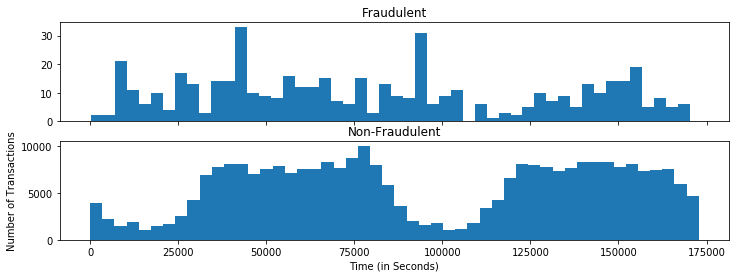

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [12,4])

ax1.hist(df.Time[df.Class == 1], bins = 50)
ax1.set_title("Fraudulent")
ax2.hist(df.Time[df.Class == 0], bins = 50)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

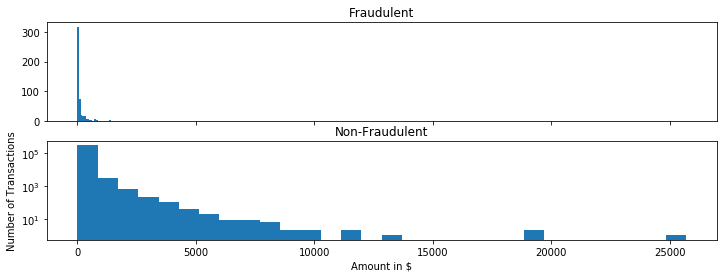

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [12,4])

ax1.hist(df.Amount[df.Class == 1], bins = 30)
ax1.set_title("Fraudulent")
ax2.hist(df.Amount[df.Class == 0], bins = 30)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Amount in $')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [7]:
df["Normalized_Amount"] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
#Amount variable is skewed. So we will standardize it with mean = 0 and sd = 1.
#Drop time & amount variable
df = df.drop(['Time', 'Amount'], axis = 1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Normalized_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [8]:
Class = [len(df.loc[df.Class == 1]), len(df.loc[df.Class == 0])]
pd.Series(Class, index = ['Fraudulent', 'Non-fraudulent'], name = 'target')

Fraudulent           492
Non-fraudulent    284315
Name: target, dtype: int64

In [9]:
#Percentage of minority(fraudulent) class
print('% of Fraudulent Class = {:.3f}%'.format(len(df[df.Class == 1])*100 / len(df)))

% of Fraudulent Class = 0.173%


In [13]:
def results(balancing_technique):
    print(balancing_technique)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
    model_name = ["LR", "SVM", "RF"]
    LR= LogisticRegression(random_state = 0)
    

    for clf,i in zip([LR], model_name):
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        print("#"*25,i,"#"*25)
        print("Training Accuracy = {:.3f}".format(model.score(X_train, y_train)))
        print("Test Accuracy = {:.3f}".format(model.score(X_test, y_test)))
        print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_pred)))
        #Confusion Matrix
        print(confusion_matrix(y_test, y_pred))
        print("-"*15,"CLASSIFICATION REPORT","-"*15)
        print(classification_report(y_test, y_pred))
        
        #precision-recall curve
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
        avg_pre = average_precision_score(y_test, y_pred_prob)
        ax1.plot(precision, recall, label = i+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
        ax1.set_xlabel('Precision', fontsize = 14)
        ax1.set_ylabel('Recall', fontsize = 14)
        ax1.set_title('Precision-Recall Curve', fontsize = 18)
        ax1.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_pr - 0.5))
        ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

        #roc-curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr,tpr)
        ax2.plot(fpr,tpr, label = i+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
        ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
        ax2.set_xlabel("False Positive Rate", fontsize = 14)
        ax2.set_ylabel("True Positive Rate", fontsize = 14)
        ax2.set_title("ROC Curve", fontsize = 18)
        ax2.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_roc - 0.5))
        ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
        plt.tight_layout()

In [14]:
X = df.drop(columns = 'Class')
y = df['Class']
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Without Balancing
######################### LR #########################
Training Accuracy = 0.999
Test Accuracy = 0.999
ROC_AUC_score : 0.809453
[[85284    12]
 [   56    91]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.88      0.62      0.73       147

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



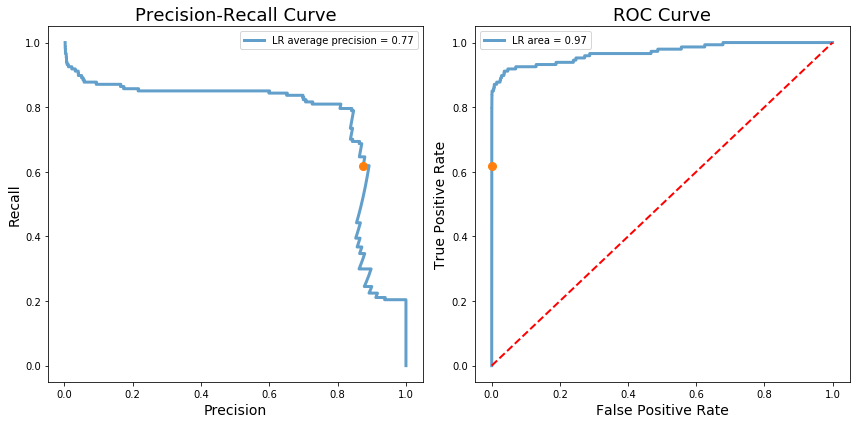

In [15]:
results("Without Balancing")

In [16]:
#DOWNSAMPLING

In [17]:
print("Minority Class =", len(df[df.Class == 1]))

Minority Class = 492


In [18]:
train_majority = df[df.Class == 0]
train_minority = df[df.Class == 1]
train_majority_downsampled = resample(train_majority, replace = False, n_samples = 492, random_state = 0)
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

In [19]:
X = train_downsampled.drop(columns = 'Class')
y = train_downsampled['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


Down Sampling
######################### LR #########################
Training Accuracy = 0.951
Test Accuracy = 0.929
ROC_AUC_score : 0.929256
[[141   6]
 [ 15 134]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       147
           1       0.96      0.90      0.93       149

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



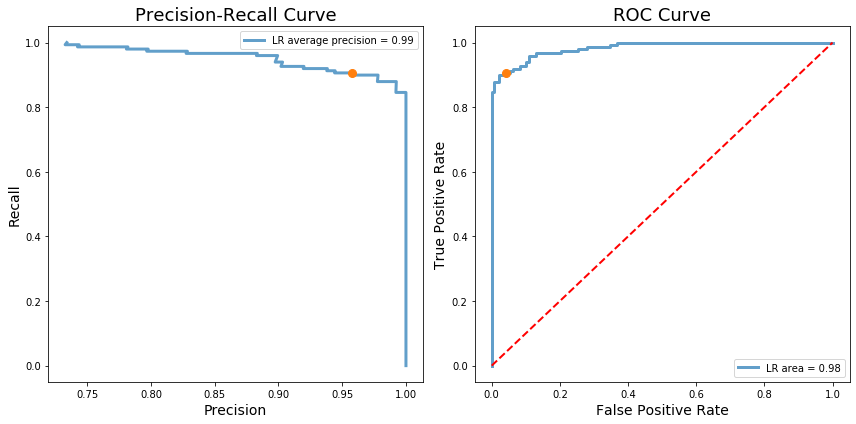

In [20]:
results("Down Sampling")

In [21]:
#UPSAMPLING

In [22]:
#Note in up sampling, first split the minority class data into train and test set and then up-sample the train data and test it with test data
X = df.drop(columns = 'Class')
y = df['Class']
#First split data into train and test
X_train_us, X_test, y_train_us, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
#Now resample the train data
df_us = pd.concat([X_train_us, y_train_us], axis = 1)
train_majority = df_us[df_us.Class == 0]
train_minority = df_us[df_us.Class == 1]
train_majority.shape, train_minority.shape

((199019, 30), (345, 30))

In [23]:
train_minority_upsampled = resample(train_minority, replace = True, n_samples = 199019, random_state = 0)
print(train_majority.shape, train_minority_upsampled.shape)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
X_train = train_upsampled.drop(columns = 'Class')
y_train = train_upsampled['Class']

(199019, 30) (199019, 30)


Up Sampling
######################### LR #########################
Training Accuracy = 0.946
Test Accuracy = 0.977
ROC_AUC_score : 0.944393
[[83353  1943]
 [   13   134]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85296
           1       0.06      0.91      0.12       147

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.98      0.99     85443



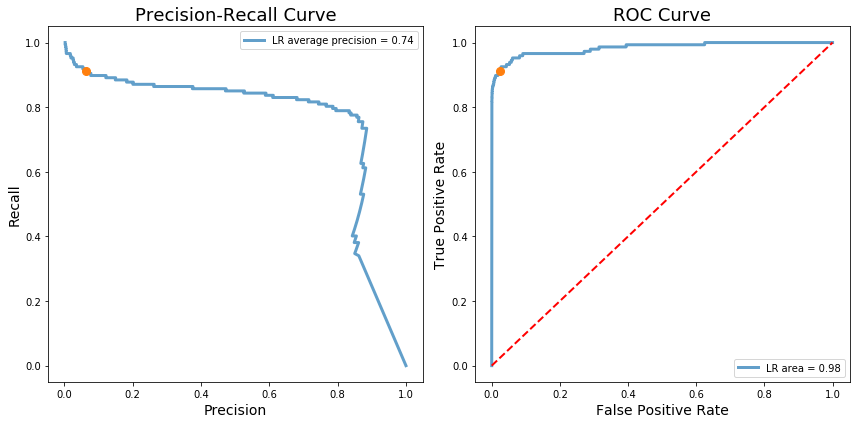

In [24]:
results("Up Sampling")